In [1]:
from imageio import imread, imsave
import numpy as np
import cv2
import meshplot
from imageio import imread, imsave
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import meshplot as mp
from skimage.color import rgb2gray
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.transform import SimilarityTransform
from skimage.feature import plot_matches
import scipy
import math
import random

# Reference database

In [3]:
class Database(object):
    
    def __init__(self, querykp, trainkp, queryDes, trainDes, queryIdx, trainIdx,
                 querypt, trainpt, matches_):
       
        self.kp1 = np.array(querykp)
        self.kp2 = np.array(trainkp)
        self.des1 = np.array(queryDes)
        self.des2 = np.array(trainDes)
        self.idx1 = np.array(queryIdx)
        self.idx2 = np.array(trainIdx)
        self.pt1 = querypt
        self.pt2 = trainpt
        self.matches = np.array(matches_)
    
    def findMatch(self, pt, angle, scale, sift):
        '''
        Query with a point in the input image
        Returns: location, orientation, scale of the input and ref point (in order)
        '''
        # find the index of the give point
        idx = -1
        for i in range(self.pt2.shape[0]):
            if self.pt2[i][0] == pt[0] and self.pt2[i][1] == pt[1]:
                kpidx = self.idx2[i]
                if self.kp2[kpidx].angle == angle:
                    if self.kp2[kpidx].size == scale:
                        if np.array_equal(sift, self.des2[kpidx]):
                            idx = i
                            break
        if idx == -1:
            print('not found')
        # find the first match
        kpidx = self.idx2[idx]
        queryIdx = -1
        for i in range(self.matches.shape[0]):
            if kpidx == self.matches[i][0].trainIdx:
                queryIdx = self.matches[i][0].queryIdx
                break
        trainKpt = self.kp2[kpidx]
        queryKpt = self.kp1[queryIdx]
        
        return trainKpt.pt, trainKpt.angle, trainKpt.size, queryKpt.pt, queryKpt.angle, queryKpt.size

    def findBox(self, pt, angle, scale, sift, corners):
        '''
        Given a point in the input img
        Returns the param of bounding box
        '''
        inputpt, inputangle, inputscale, refpt, refangle, refscale = self.findMatch(pt, angle, scale, sift)
        translation = (inputpt[0] - refpt[0], inputpt[1] - refpt[1])
        scale = inputscale / refscale
        rotation = (inputangle - refangle) * np.pi / 180
        tform = SimilarityTransform(scale=scale, rotation=rotation, translation=translation)
        new_corners = tform(corners)
        
        return new_corners

# Helper functions

In [4]:
def in_range(pt, img):
    '''
    return true if pt is within the img
    '''
    if pt[0] >= 0 and pt[0] < img.shape[1]:
        if pt[1] >= 0 and pt[1] < img.shape[0]:
            return True
        
    return False

def fit_homog(sample):
    
    A = []
    for j in sample:
        x = j[0][0] # src x
        y = j[0][1] # src y
        xp = j[1][0] # dst x
        yp = j[1][1] # dst y
        row1 = np.array([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        row2 = np.array([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
        A.append(row1)
        A.append(row2)
    A = np.array(A)
    AtA = np.dot(np.transpose(A), A)
    w, v = np.linalg.eig(AtA)
    idx = np.argmin(w)
    homog = v[:,idx].reshape(3,3)
    
    return homog

def ransac(src, dst, min_samples=4, residual_threshold=1, max_trials=300):
    
    homog_arr = []
    inlier_arr = []
    
    for _ in range(max_trials):
        # randomly select "min_samples" many correspondences
        sample = random.sample(list(zip(src, dst)), min_samples)

        # hypothesize a homography with the selected samples
        homog = fit_homog(sample)
        homog /= homog[2,2]

        # find inliers
        inliers = []
        for i in range(len(src)):
            src_homo = np.append(src[i], 1)
            est = homog @ src_homo
            est /= est[2]
            if np.linalg.norm(dst[i]-est[:2]) <= 1:
                inliers.append([src[i], dst[i]])
        
        if len(inliers) >= min_samples:
            # refit homography to inliers
            homog = fit_homog(inliers)
            homog /= homog[2,2]
        
        homog_arr.append(homog)
        inlier_arr.append(len(inliers))
    
    index = np.argmax(inlier_arr)
    
    return homog_arr[index]

def extract_correspondences(im1, im2, coeff=0.5): # im2 is input img

    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    pts1 = []
    pts2 = []

    sift = cv2.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(im1,None)
    kp2, des2 = sift.detectAndCompute(im2,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2) # order: queryDes, trainDes
    
    matches_for_plot = []
    idx1 = []
    idx2 = []
    for m,n in matches:
        if m.distance < coeff*n.distance:
            matches_for_plot.append([m])
            pt1 = kp1[m.queryIdx].pt
            pt2 = kp2[m.trainIdx].pt
            idx1.append(m.queryIdx)
            idx2.append(m.trainIdx)
            pts1.append((int(round(pt1[0])), int(round(pt1[1]))))
            pts2.append((int(round(pt2[0])), int(round(pt2[1]))))
    
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    ds = Database(kp1, kp2, des1, des2, idx1, idx2, pts1, pts2, matches_for_plot)

    return matches_for_plot, kp1, kp2, pts1, pts2, idx1, idx2, des1, des2, ds

# Detector

In [5]:
def detect(ref, stop, NUM_PEAK, LENGTH, PT_IN_IMG, COEFF, THRESHOLD, TRIALS, EXAMPLE=False):
    
    ##############################
    # Find keypoints and matches #
    ##############################
    matches_for_plot, kp1, kp2, pts1, pts2, idx1, idx2, des1, des2, ds = extract_correspondences(ref, stop, coeff=COEFF)

    img3 = cv2.drawMatchesKnn(ref, kp1, stop, kp2, matches_for_plot, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    if EXAMPLE:
        plt.figure(figsize=(20, 10))
        plt.imshow(img3)
        plt.show()

    #######################################################################################
    # Given a point in the input image, find the bounding box parameters in the input img #
    #######################################################################################
    corners = [[0, 0],
               [ref.shape[1]-1, 0],
               [ref.shape[1]-1, ref.shape[0]-1],
               [0, ref.shape[0]-1]]

    stop_copy = stop.copy()
    if EXAMPLE:
        plt.figure(figsize=(20, 10))

    boxparams = []
    boxparams_idx = []
    for i in range(pts2.shape[0]):
        boxparam = ds.findBox(pts2[i], kp2[idx2[i]].angle, kp2[idx2[i]].size, des2[idx2[i]], corners)
        if PT_IN_IMG == 3:
            if (in_range(boxparam[0], stop) and in_range(boxparam[1], stop) and in_range(boxparam[2], stop)) or \
               (in_range(boxparam[0], stop) and in_range(boxparam[1], stop) and in_range(boxparam[3], stop)) or \
               (in_range(boxparam[0], stop) and in_range(boxparam[2], stop) and in_range(boxparam[3], stop)) or \
               (in_range(boxparam[1], stop) and in_range(boxparam[2], stop) and in_range(boxparam[3], stop)):
                boxparams.append(boxparam)
                boxparams_idx.append(i)
                if EXAMPLE:
                    for j in boxparam:
                        plt.plot(j[0], j[1], 'ro')
                    poly = cv2.polylines(stop_copy, np.int32([boxparam]), True, (0,0,255), thickness=2)

        if PT_IN_IMG == 1:
            if in_range(boxparam[0], stop) or in_range(boxparam[1], stop) or\
               in_range(boxparam[2], stop) or in_range(boxparam[3], stop):
                boxparams.append(boxparam)
                boxparams_idx.append(i)
                if EXAMPLE:
                    for j in boxparam:
                        plt.plot(j[0], j[1], 'ro')
                    poly = cv2.polylines(stop_copy, np.int32([boxparam]), True, (0,0,255), thickness=2)

    boxparams = np.array(boxparams)
    
    if EXAMPLE:
        plt.imshow(stop_copy)

    ################
    # Hough Voting #
    ################
    dict_votes = {}
    dict_kpt = {}

    for i in range(boxparams.shape[0]):
        vote = []
        for loc in boxparams[i]: # assign each coordinate to a "cluster"
            cluster_x = loc[0] // LENGTH + 1
            cluster_y = loc[1] // LENGTH + 1
            vote.append(((cluster_x-1)*LENGTH + LENGTH/2, (cluster_y-1)*LENGTH + LENGTH/2))

        vote = tuple(vote)
        if vote in dict_votes:
            dict_votes[vote] += 1
        else:
            dict_votes[vote] = 1
        if vote in dict_kpt:
            dict_kpt[vote].append(boxparams_idx[i])
        else:
            dict_kpt[vote] = [boxparams_idx[i]]

    # get coordinates with max, second max, third max... votes depending on NUM_PEAK
    x = sorted(((v,k) for k,v in dict_votes.items()))
    coor_arr = []
    for i in range(1, NUM_PEAK+1):
        coor_arr.append(x[-i][1])

    # use coor to backtrack keypoints idx
    kp_id = []
    for i in coor_arr:
        kp_id += dict_kpt[i]

    if EXAMPLE:
        # show the bounding boxes that are most voted for
        tests = []
        plt.figure(figsize=(20, 10))
        stop_copy = stop.copy()
        for i in kp_id:
            test = ds.findBox(pts2[i], kp2[idx2[i]].angle, kp2[idx2[i]].size, des2[idx2[i]], corners)
            tests.append(test)
            for i in test:
                plt.plot(i[0], i[1], 'ro')
            poly = cv2.polylines(stop_copy, np.int32([test]), True, (0,0,255), thickness=2)

        plt.imshow(stop_copy)

    ########################################################
    # Use selected keypoints to fit homography with RANSAC #
    ########################################################
    src = list(pts1[kp_id]) # ref keypoints
    dst = list(pts2[kp_id]) # input keypoints

    homog = ransac(src, dst, min_samples=4, residual_threshold=THRESHOLD, max_trials=TRIALS)

    ########################################
    # Display and return detection results #
    ########################################
    plt.figure(figsize=(16, 8))
    plt.axis('off')

    corners = [[0, 0],
               [ref.shape[1]-1, 0],
               [ref.shape[1]-1, ref.shape[0]-1],
               [0, ref.shape[0]-1]]
    corners_homog = corners.copy()
    stop_copy = stop.copy()
    new_corners = []
    for i in corners_homog:
        i.append(1)
        newc = homog @ i
        newc /= newc[2]
        newc = newc[:2]
        plt.plot(newc[0], newc[1], 'ro')
        new_corners.append(newc)
        
    poly = cv2.polylines(stop_copy, np.int32([new_corners]), True, (0,0,255), thickness=5)
    plt.imshow(stop_copy)
    plt.show()
    
    
    return new_corners

# Results

reference image


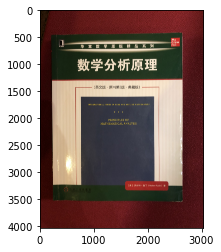

In [9]:
ref = imread("./book/book_ref.jpeg")
print('reference image')
plt.imshow(ref)

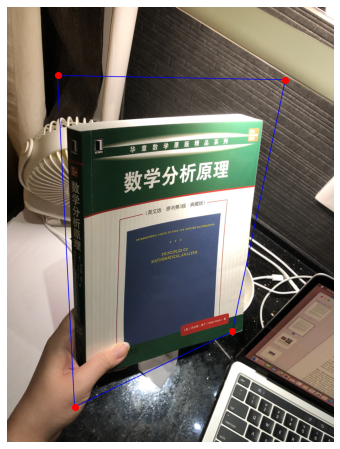

Coordinates of the detected bounding box: [array([466.55943448, 634.31092454]), array([2573.03390311,  674.25274214]), array([2083.37547402, 3007.92171652]), array([ 624.77005129, 3706.63934848])]


In [6]:
num_peak = 2
length = 500
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./book/book3.jpeg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

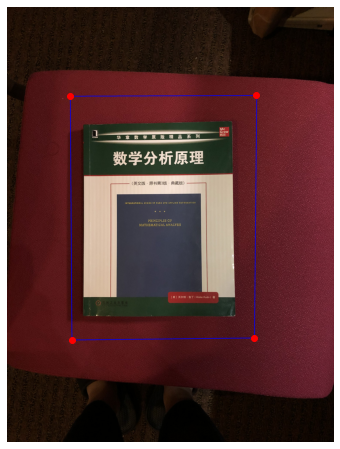

Coordinates of the detected bounding box: [array([585.41120818, 826.84113551]), array([2309.71793423,  820.12394579]), array([2288.85450252, 3067.86436206]), array([ 600.56762651, 3086.0933461 ])]


In [10]:
num_peak = 2
length = 500
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./book/book1.jpeg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

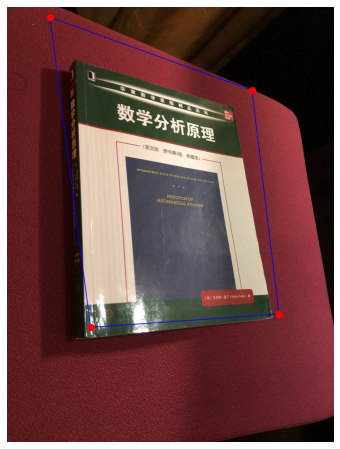

Coordinates of the detected bounding box: [array([396.99696291,  94.12286183]), array([2265.05128719,  772.10796733]), array([2514.8900213 , 2846.26707601]), array([ 773.64425757, 2969.78057674])]


In [12]:
num_peak = 2
length = 500
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./book/book2.jpeg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

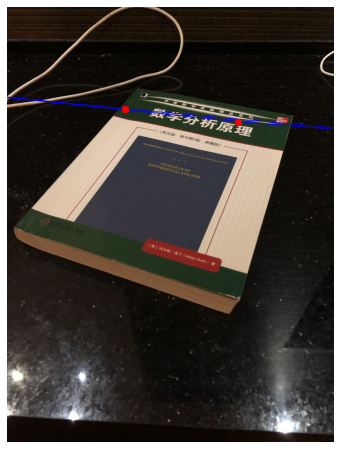

Coordinates of the detected bounding box: [array([2140.64192577, 1062.70659069]), array([4123.86475525, 1219.99313529]), array([1096.17015612,  944.6826419 ]), array([-1528.09263659,   679.54826779])]


In [13]:
num_peak = 2
length = 500
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./book/book4.jpeg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

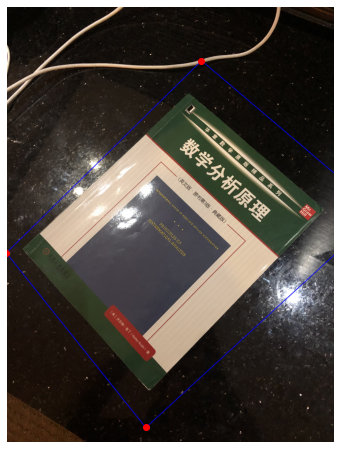

Coordinates of the detected bounding box: [array([1799.40648113,  497.5771071 ]), array([3454.24468393, 1904.46350139]), array([1283.74205998, 3898.73583129]), array([  -7.7380689 , 2279.70607708])]


In [14]:
num_peak = 2
length = 500
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./book/book5.jpeg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

reference image


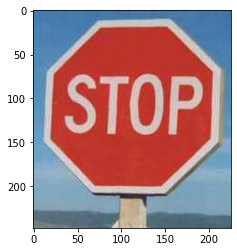

In [16]:
ref = imread("./stopsign/stop-reference.jpg")
print('reference image')
plt.imshow(ref)

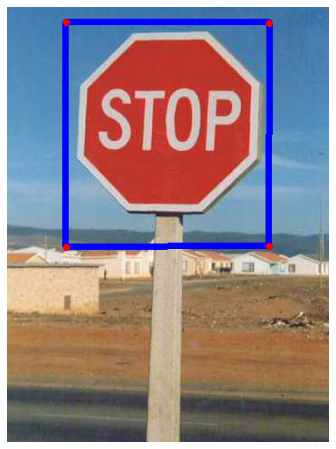

Coordinates of the detected bounding box: [array([64.573126  , 16.45158536]), array([289.00674843,  16.91244909]), array([288.60408262, 263.64441673]), array([ 64.68117087, 264.45107118])]


In [17]:
num_peak = 2
length = 50
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./stopsign/stop1.jpg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

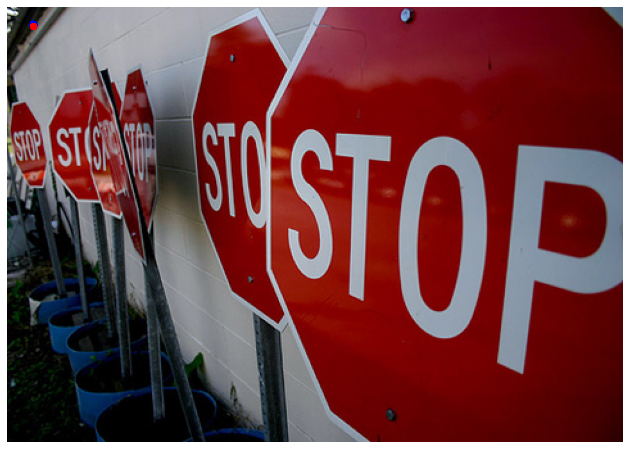

Coordinates of the detected bounding box: [array([20.00000003, 13.99999993]), array([20., 14.]), array([20.00000001, 14.        ]), array([20., 14.])]


In [18]:
num_peak = 2
length = 120
pt_in_img = 1
coeff = 0.8
threshold = 1
trials = 300

stop = imread("./stopsign/stop2.jpg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

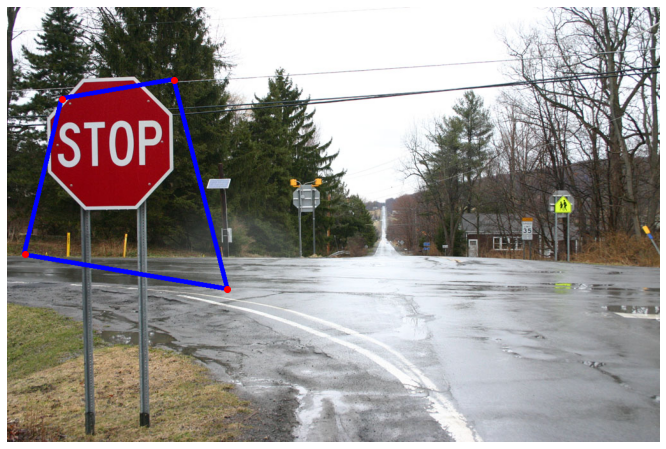

Coordinates of the detected bounding box: [array([ 85.0649503 , 143.61933614]), array([261.25634137, 113.95796093]), array([345.01038177, 442.01424937]), array([ 26.70014485, 388.01027165])]


In [19]:
num_peak = 1
length = 60
pt_in_img = 1
coeff = 0.75
threshold = 1
trials = 300

stop = imread("./stopsign/stop3.jpg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

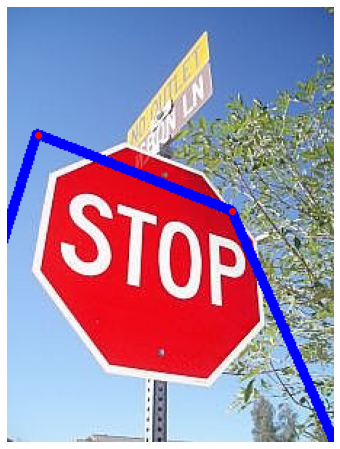

Coordinates of the detected bounding box: [array([20.53215603, 87.53589105]), array([154.30890317, 140.33557872]), array([237.56503692, 327.86656807]), array([-56.99576598, 329.39864049])]


In [20]:
num_peak = 2
length = 60
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

stop = imread("./stopsign/stop4.jpg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

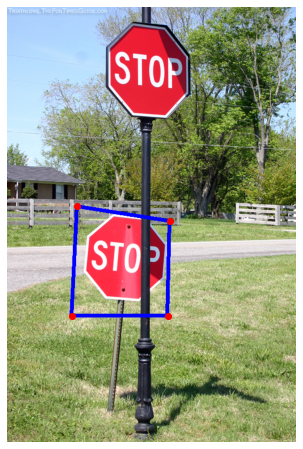

Coordinates of the detected bounding box: [array([128.64024479, 366.2290154 ]), array([298.70313516, 393.01112285]), array([294.52002741, 567.49579324]), array([118.1596042 , 567.39214651])]


In [21]:
num_peak = 1
length = 60
pt_in_img = 1
coeff = 0.75
threshold = 1
trials = 300

stop = imread("./stopsign/stop5.jpg")

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=False)
print('Coordinates of the detected bounding box:', coor)

# An example with intermediate results displayed

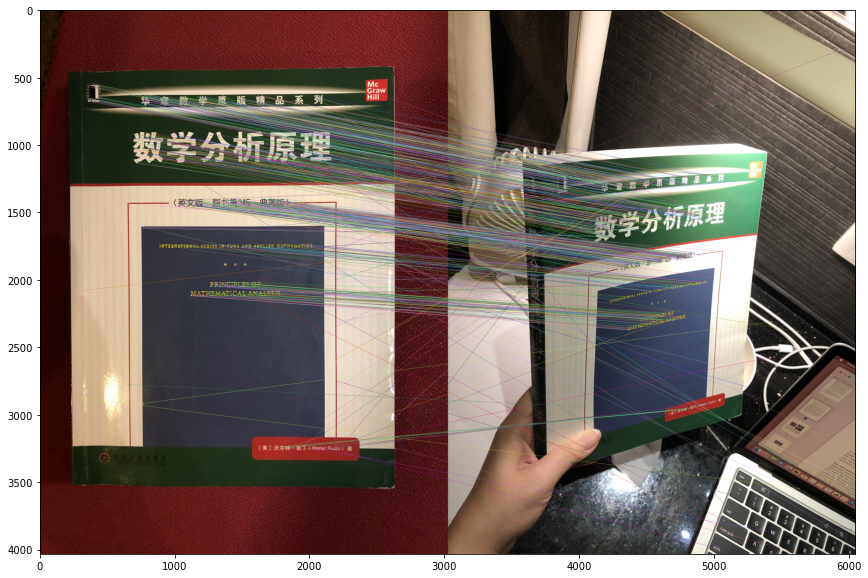

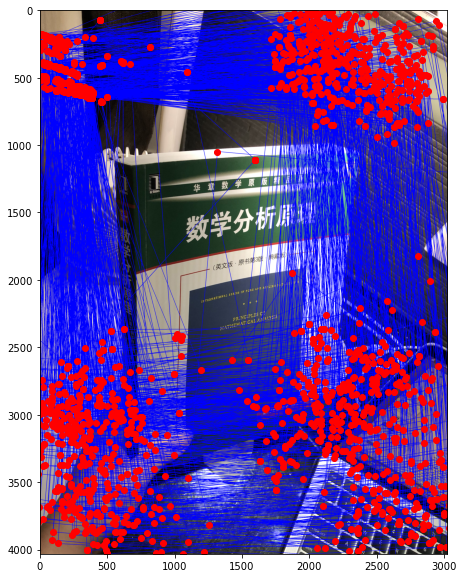

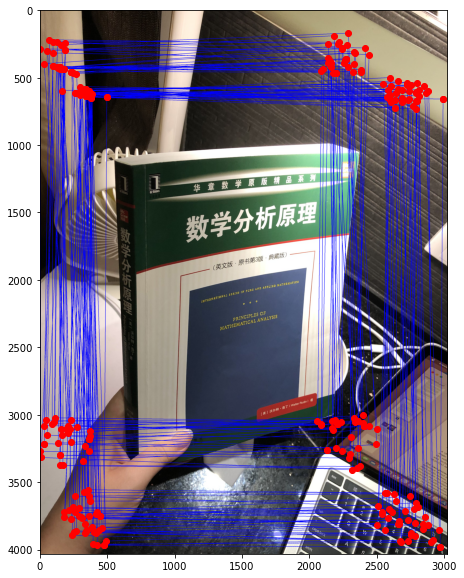

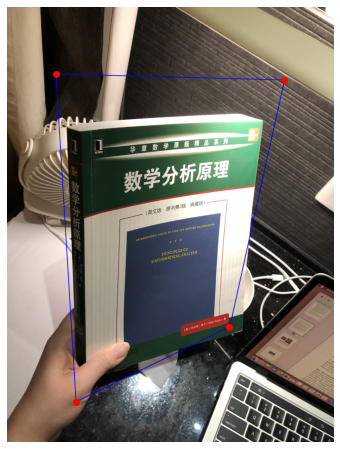

Coordinates of the detected bounding box: [array([452.60326885, 620.54518329]), array([2566.27086142,  676.26901628]), array([2060.04570909, 2963.92130131]), array([ 638.8998395, 3659.2479004])]


In [22]:
ref = imread("./book/book_ref.jpeg")
stop = imread("./book/book3.jpeg")

num_peak = 2
length = 500
pt_in_img = 3
coeff = 0.7
threshold = 1
trials = 300

coor = detect(ref, stop, num_peak, length, pt_in_img, coeff, threshold, trials, EXAMPLE=True)
print('Coordinates of the detected bounding box:', coor)